In [1]:
# find files recursively
from glob import glob

# parse tb files
from tbparse import SummaryReader

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# searching df rows with np.where()
import numpy as np
import pandas as pd

import re

from scipy import stats
import tensorboard as tb
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

2024-10-01 12:39:22.254541: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def extract_tb_values(logdir, value_name, print_tags = False):
    event_acc = EventAccumulator(logdir)
    event_acc.Reload()
    
    if print_tags:
        print(event_acc.Tags()['scalars'])
        
    if value_name not in event_acc.Tags()['scalars']:
        print("Scalar not found.")
        return [], [], []
    else:
        events = event_acc.Scalars(value_name)
    
    steps = [event.step for event in events]
    values = [event.value for event in events]
    wall_time = [event.wall_time for event in events]
    
    return values, steps, wall_time

In [3]:
def get_rolling_avg(values, window_size):
    return np.convolve(values, np.ones(window_size) / window_size, mode = 'valid')

In [4]:
def get_names_meeting_env(logdir_list):
    name_list = []
    for file_name in logdir_list:
        name = re.sub("training/spiderenv_training/((s)?\d/)?", "", re.sub("(_\d)?((_)?\d)?/tensorboard_logs/.*", "",  file_name))
        name_list.append(name)
        
    return name_list

In [5]:
def get_df_in_steps(logdir_list, plot_names, value_name, rolling_avg_window = 1, wall_time_avg = False):
    df = pd.DataFrame()
    
    if wall_time_avg: 
        x = "wall_time"
    else:
        x = "steps"
        
    for (file_name, plot_name) in zip(logdir_list, plot_names):
        values, steps, wall_time = extract_tb_values(file_name, value_name)

        if values != []:
            value_dict = {value_name.replace("reward/", "rollout/"): values, 
                          "steps": steps, 
                          "wall_time": [(time - wall_time[0]) / 60. for time in wall_time]}
            
            temp_df = pd.DataFrame(value_dict)
            
            bin_edges = np.arange(0, temp_df[x].max() + rolling_avg_window, rolling_avg_window, dtype = np.int32)
            temp_df['bin'] = pd.cut(temp_df[x], bins = bin_edges, labels = bin_edges[:-1])

            def weighted_avg(group):
                if not np.isclose(group[x].sum(), 0.):
                    # Calculate the weighted average over the bins weighted by the steps
                    return pd.Series({
                        value_name.replace("reward/", "rollout/"): np.average(group[value_name.replace("reward/", "rollout/")], weights = group[x]),
                    })
                else:
                    return None

            temp_df = temp_df.groupby(['bin'], observed = False)[[value_name.replace("reward/", "rollout/"), "steps", "wall_time", "bin"]].apply(weighted_avg, include_groups = True).reset_index().dropna()
            
            # add missing bins
            all_bins = pd.DataFrame({'bin': bin_edges[:-1]})

            temp_df = pd.merge(all_bins, temp_df, on = 'bin', how = 'left')

            # interpolate missing values
            temp_df[value_name.replace("reward/", "rollout/")] = temp_df[value_name.replace("reward/", "rollout/")].interpolate()
            
            temp_df = temp_df.rename(columns = {"bin": x})
            temp_df["run"] = np.repeat(plot_name, len(temp_df.index))
            
            df = df._append(temp_df)
        
        print(plot_name + " done!")
     
    return df  

In [6]:
def get_tb_files(env_name, run_name_list):
    tb_files = []
    
    for run_name in run_name_list:
        print("training/" + env_name + "/" + run_name + "/**/events*")
        for filename in glob(("training/" + env_name + "/" + run_name + "/**/events*"), recursive=True):
            if "agent" in filename:
                if "agent1" in filename:
                    tb_files.append(filename)
            else:
                tb_files.append(filename)
                
    return tb_files

# DQN

In [7]:
run_list = [
    "dqn_3_spider_10",
    "dqn_3_spider_11",
    "dqn_3_spider_12",
    "dqn_3_spider_13",
    "seqdqn_3_spider_8",
    "seqdqn_3_spider_9",
    "seqdqn_3_spider_11",
]
tb_files = get_tb_files("spiderenv_training", run_list)
tb_files

training/spiderenv_training/dqn_3_spider_10/**/events*
training/spiderenv_training/dqn_3_spider_11/**/events*
training/spiderenv_training/dqn_3_spider_12/**/events*
training/spiderenv_training/dqn_3_spider_13/**/events*
training/spiderenv_training/seqdqn_3_spider_8/**/events*
training/spiderenv_training/seqdqn_3_spider_9/**/events*
training/spiderenv_training/seqdqn_3_spider_11/**/events*


['training/spiderenv_training/dqn_3_spider_10/tensorboard_logs/events.out.tfevents.1726144451.v100gpu20.3629373.0',
 'training/spiderenv_training/dqn_3_spider_11/tensorboard_logs/events.out.tfevents.1727177854.v100gpu4.2848101.0',
 'training/spiderenv_training/dqn_3_spider_12/tensorboard_logs/events.out.tfevents.1727177854.v100gpu9.80797.0',
 'training/spiderenv_training/dqn_3_spider_13/tensorboard_logs/events.out.tfevents.1726145433.v100gpu21.2718829.0',
 'training/spiderenv_training/seqdqn_3_spider_8/tensorboard_logs/events.out.tfevents.1719186294.v100gpu11.1582668.0',
 'training/spiderenv_training/seqdqn_3_spider_8/tensorboard_logs/train_avg_Q_target_value_agent1/events.out.tfevents.1719186298.v100gpu11.1582668.11',
 'training/spiderenv_training/seqdqn_3_spider_8/tensorboard_logs/train_average_loss_agent1/events.out.tfevents.1719186298.v100gpu11.1582668.5',
 'training/spiderenv_training/seqdqn_3_spider_8/tensorboard_logs/rollout_reward_sum_agent1/events.out.tfevents.1719186296.v100g

In [8]:
df_3 = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/eval_reward_sum", 400)
df_3 = pd.concat([df_3, get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "reward/reward_sum", 400)])

dqn_3_spider done!
dqn_3_spider done!
dqn_3_spider done!
dqn_3_spider done!
seqdqn_3_spider done!
Scalar not found.
seqdqn_3_spider done!
Scalar not found.
seqdqn_3_spider done!
Scalar not found.
seqdqn_3_spider done!
Scalar not found.
seqdqn_3_spider done!
seqdqn_3_spider done!
Scalar not found.
seqdqn_3_spider done!
Scalar not found.
seqdqn_3_spider done!
Scalar not found.
seqdqn_3_spider done!
Scalar not found.
seqdqn_3_spider done!
seqdqn_3_spider done!
Scalar not found.
seqdqn_3_spider done!
Scalar not found.
seqdqn_3_spider done!
Scalar not found.
dqn_3_spider done!
Scalar not found.
dqn_3_spider done!
Scalar not found.
dqn_3_spider done!
Scalar not found.
dqn_3_spider done!
Scalar not found.
seqdqn_3_spider done!
Scalar not found.
seqdqn_3_spider done!
Scalar not found.
seqdqn_3_spider done!
Scalar not found.
seqdqn_3_spider done!
Scalar not found.
seqdqn_3_spider done!
Scalar not found.
seqdqn_3_spider done!
Scalar not found.
seqdqn_3_spider done!
Scalar not found.
seqdqn_3_spi

/tmp/ipykernel_304369/1228410186.py:7: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  axs.legend(title = "Algorithm", loc = "upper left", labels = ["Seq DQN", "_nolegend_", "DQN"], frameon = False)


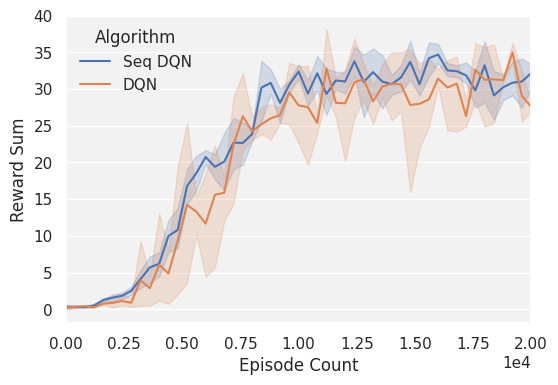

In [9]:
# df_3 = df_3[df_3["steps"] <= 20000]
sns.set_theme(style = "dark", rc = {"axes.facecolor": ".95"})

fig, axs = plt.subplots(1, 1, figsize=(6,4))

sns.lineplot(df_3[df_3["steps"] <= 20000], x = "steps", y = "rollout/eval_reward_sum", hue = "run", ax = axs)
axs.legend(title = "Algorithm", loc = "upper left", labels = ["Seq DQN", "_nolegend_", "DQN"], frameon = False)
axs.grid(axis = "y")
axs.set_ylabel('Reward Sum')
axs.set_xlabel('Episode Count')
axs.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
axs.margins(x=0)

fig.savefig('plots/spider_dqn.png', dpi = 300, bbox_inches='tight')

# SAC

In [10]:
run_list = [
    "seqsac_3_spider_7",
    "seqsac_3_spider_8",
    "seqsac_3_spider_9",
    "seqsac_3_spider_10",
    "seqsac_3_spider_11",
    "sac_3_spider_1",
    "sac_3_spider_2",
    "sac_3_spider_3",
]
tb_files = get_tb_files("spiderenv_training", run_list) 
tb_files

training/spiderenv_training/seqsac_3_spider_7/**/events*
training/spiderenv_training/seqsac_3_spider_8/**/events*
training/spiderenv_training/seqsac_3_spider_9/**/events*
training/spiderenv_training/seqsac_3_spider_10/**/events*
training/spiderenv_training/seqsac_3_spider_11/**/events*
training/spiderenv_training/sac_3_spider_1/**/events*
training/spiderenv_training/sac_3_spider_2/**/events*
training/spiderenv_training/sac_3_spider_3/**/events*


['training/spiderenv_training/seqsac_3_spider_7/tensorboard_logs/events.out.tfevents.1726147513.v100gpu23.417474.0',
 'training/spiderenv_training/seqsac_3_spider_7/tensorboard_logs/train_avg_alpha_loss_agent1/events.out.tfevents.1726147521.v100gpu23.417474.11',
 'training/spiderenv_training/seqsac_3_spider_7/tensorboard_logs/train_avg_actor_loss_agent1/events.out.tfevents.1726147521.v100gpu23.417474.5',
 'training/spiderenv_training/seqsac_3_spider_7/tensorboard_logs/train_avg_alpha_agent1/events.out.tfevents.1726147521.v100gpu23.417474.14',
 'training/spiderenv_training/seqsac_3_spider_7/tensorboard_logs/train_avg_policy_entr_agent1/events.out.tfevents.1726147521.v100gpu23.417474.17',
 'training/spiderenv_training/seqsac_3_spider_7/tensorboard_logs/train_avg_critic_loss_agent1/events.out.tfevents.1726147521.v100gpu23.417474.8',
 'training/spiderenv_training/seqsac_3_spider_7/tensorboard_logs/rollout_reward_sum_agent1/events.out.tfevents.1726147514.v100gpu23.417474.2',
 'training/spid

In [11]:
df_3 = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/eval_reward_sum", 300)
df_3 = pd.concat([df_3, get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "reward/eval_reward_sum", 300)])

seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
Scalar not found.
seqsac_3_spide

In [12]:
# df_3 = df_3[df_3["steps"] < 17500]
# df_3 = df_3[df_3["steps"] < 20000]

/tmp/ipykernel_304369/2556463399.py:6: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  axs.legend(title = "Algorithm", loc = "lower right", labels = ["Seq SAC", "_nolegend_", "SAC"], frameon = False)


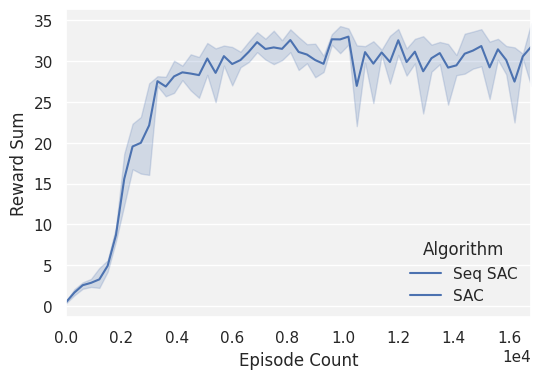

In [13]:
sns.set_theme(style = "dark", rc = {"axes.facecolor": ".95"})

fig, axs = plt.subplots(1, 1, figsize=(6,4))

sns.lineplot(df_3[df_3["steps"] < 17000], x = "steps", y = "rollout/eval_reward_sum", hue = "run", ax = axs)
axs.legend(title = "Algorithm", loc = "lower right", labels = ["Seq SAC", "_nolegend_", "SAC"], frameon = False)
axs.grid(axis = "y")
axs.set_ylabel('Reward Sum')
axs.set_xlabel('Episode Count')
axs.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
axs.margins(x=0)


In [14]:
run_list = [
    "seqsac_3_spider_7",
    "seqsac_3_spider_8",
    "seqsac_3_spider_9",
    "seqsac_3_spider_10",
    "seqsac_3_spider_11",
    "sac_3_spider_big",
    "sac_3_spider_big2",
    "sac_3_spider_big3",
]
tb_files = get_tb_files("spiderenv_training", run_list) 

df_3 = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/reward_sum", 300)
df_3 = pd.concat([df_3, get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "reward/reward_sum", 300)])

training/spiderenv_training/seqsac_3_spider_7/**/events*
training/spiderenv_training/seqsac_3_spider_8/**/events*
training/spiderenv_training/seqsac_3_spider_9/**/events*
training/spiderenv_training/seqsac_3_spider_10/**/events*
training/spiderenv_training/seqsac_3_spider_11/**/events*
training/spiderenv_training/sac_3_spider_big/**/events*
training/spiderenv_training/sac_3_spider_big2/**/events*
training/spiderenv_training/sac_3_spider_big3/**/events*
Scalar not found.
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
Scalar not found.
seqsac_3_spider done!
seqsac_3_spider done!
Scalar not found.
s

In [15]:
# df_3 = df_3[df_3["steps"] < 18000]
df_3 = df_3[df_3["steps"] < 20000]


/tmp/ipykernel_304369/1996877455.py:6: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  axs.legend(title = "Algorithm", loc = "lower right", labels = ["Seq SAC", "_nolegend_", "SAC"], frameon = False)


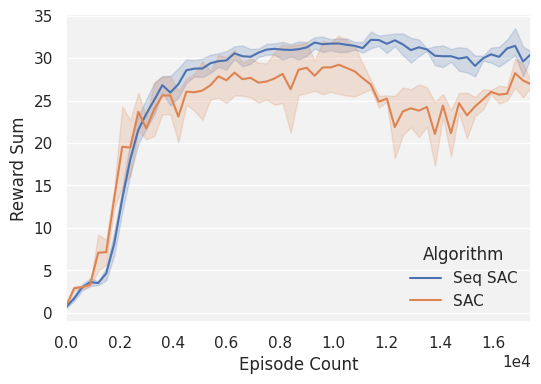

In [16]:
sns.set_theme(style = "dark", rc = {"axes.facecolor": ".95"})

fig, axs = plt.subplots(1, 1, figsize=(6,4))

sns.lineplot(df_3[df_3["steps"] < 17550], x = "steps", y = "rollout/reward_sum", hue = "run", ax = axs)
axs.legend(title = "Algorithm", loc = "lower right", labels = ["Seq SAC", "_nolegend_", "SAC"], frameon = False)
axs.grid(axis = "y")
axs.set_ylabel('Reward Sum')
axs.set_xlabel('Episode Count')
axs.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
axs.margins(x=0)

fig.savefig('plots/spider_sac.png', dpi = 300, bbox_inches='tight')

# 4

training/spiderenv_training/sac_4_1/**/events*
training/spiderenv_training/sac_4_2/**/events*
training/spiderenv_training/sac_4_3/**/events*
training/spiderenv_training/sac_4_4/**/events*
training/spiderenv_training/seqsac_4_spider_1/**/events*
training/spiderenv_training/seqsac_4_spider_2/**/events*
training/spiderenv_training/seqsac_4_spider_3/**/events*
training/spiderenv_training/seqsac_4_spider_4/**/events*
Scalar not found.
sac done!
Scalar not found.
sac done!
Scalar not found.
sac done!
Scalar not found.
sac done!
Scalar not found.
sac done!
Scalar not found.
sac done!
Scalar not found.
sac done!
Scalar not found.
seqsac_4_spider done!
Scalar not found.
seqsac_4_spider done!
Scalar not found.
seqsac_4_spider done!
Scalar not found.
seqsac_4_spider done!
Scalar not found.
seqsac_4_spider done!
Scalar not found.
seqsac_4_spider done!
seqsac_4_spider done!
Scalar not found.
seqsac_4_spider done!
Scalar not found.
seqsac_4_spider done!
Scalar not found.
seqsac_4_spider done!
Scalar

/tmp/ipykernel_304369/1438501536.py:22: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  axs.legend(title = "Algorithm", loc = "lower right", labels = ["Seq SAC", "_nolegend_", "SAC"], frameon = False)


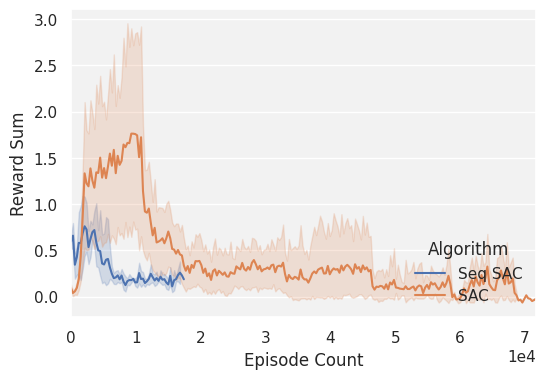

In [17]:
run_list = [
    "sac_4_1",
    "sac_4_2",
    "sac_4_3",
    "sac_4_4",
    "seqsac_4_spider_1",
    "seqsac_4_spider_2",
    "seqsac_4_spider_3",
    "seqsac_4_spider_4",
]
tb_files = get_tb_files("spiderenv_training", run_list) 

df_3 = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/reward_sum", 300)
df_3 = pd.concat([df_3, get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "reward/reward_sum", 300)])
# df_3 = df_3[df_3["steps"] < 20000]

sns.set_theme(style = "dark", rc = {"axes.facecolor": ".95"})

fig, axs = plt.subplots(1, 1, figsize=(6,4))

sns.lineplot(df_3, x = "steps", y = "rollout/reward_sum", hue = "run", ax = axs)
axs.legend(title = "Algorithm", loc = "lower right", labels = ["Seq SAC", "_nolegend_", "SAC"], frameon = False)
axs.grid(axis = "y")
axs.set_ylabel('Reward Sum')
axs.set_xlabel('Episode Count')
axs.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
axs.margins(x=0)

training/spiderenv_training/dqn_4_1/**/events*
training/spiderenv_training/dqn_4_2/**/events*
training/spiderenv_training/seqdqn_4_1/**/events*
training/spiderenv_training/seqdqn_4_2/**/events*
dqn done!
dqn done!
Scalar not found.
seqdqn done!
Scalar not found.
seqdqn done!
seqdqn done!
Scalar not found.
seqdqn done!
Scalar not found.
seqdqn done!
seqdqn done!
Scalar not found.
dqn done!
Scalar not found.
dqn done!
Scalar not found.
seqdqn done!
Scalar not found.
seqdqn done!
Scalar not found.
seqdqn done!
Scalar not found.
seqdqn done!
Scalar not found.
seqdqn done!
Scalar not found.
seqdqn done!


/tmp/ipykernel_304369/3147031401.py:18: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  axs.legend(title = "Algorithm", loc = "lower right", labels = ["Seq DQN", "_nolegend_", "DQN"], frameon = False)


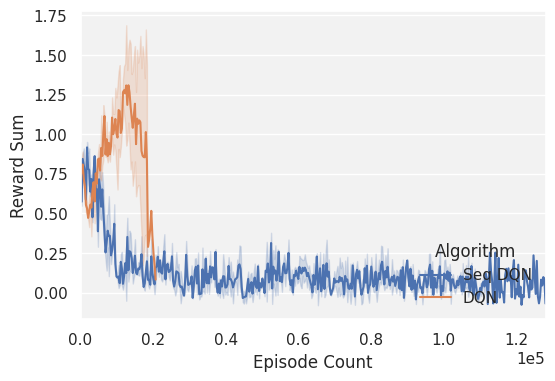

In [18]:
run_list = [
    "dqn_4_1",
    "dqn_4_2",
    "seqdqn_4_1",
    "seqdqn_4_2",
]
tb_files = get_tb_files("spiderenv_training", run_list) 

df_3 = get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "rollout/reward_sum", 300)
df_3 = pd.concat([df_3, get_df_in_steps(tb_files, get_names_meeting_env(tb_files), "reward/reward_sum", 300)])
# df_3 = df_3[df_3["steps"] < 20000]

sns.set_theme(style = "dark", rc = {"axes.facecolor": ".95"})

fig, axs = plt.subplots(1, 1, figsize=(6,4))

sns.lineplot(df_3, x = "steps", y = "rollout/reward_sum", hue = "run", ax = axs)
axs.legend(title = "Algorithm", loc = "lower right", labels = ["Seq DQN", "_nolegend_", "DQN"], frameon = False)
axs.grid(axis = "y")
axs.set_ylabel('Reward Sum')
axs.set_xlabel('Episode Count')
axs.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
axs.margins(x=0)